# Mnist手写数字识别神经网络

### 导入数据集

dict_keys(['image', 'label'])
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x26D5179BA10>
5


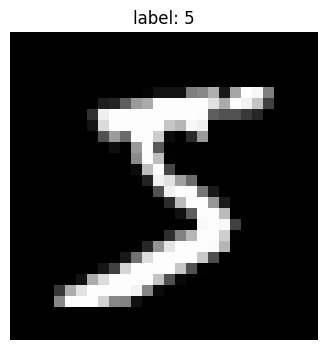

In [45]:
from random import sample
from datasets import load_from_disk
import matplotlib.pyplot as plt

dataset  = load_from_disk("D:/AILearn/Deep learning network/node/data/mnist")

train_data = dataset["train"]
test_data = dataset["test"]
sample = train_data[0]
print(sample.keys())
print(sample["image"])
print(sample["label"])

plt.figure(figsize=(4, 4))
plt.imshow(sample["image"],cmap="gray")  # 使用灰度色彩映射
plt.title(f'label: {sample["label"]}')
plt.axis('off')  # 不显示坐标轴
plt.show()


### 确定网络结构以及形状
隐藏层参数 W(784,64) b(1,64)
输出层参数 W(64,10) b(1,10)
softmax -> 概率值  
### 流程
1. 获取数据
2. 前向传播：网格结构定义
3. 损失计算
4. 反向传播 梯度下降优化
功能性模块：
· 准确率计算
· Tensorboard可视化
·  训练模型保存 加载 预测

In [46]:
import torch
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def transform_example(example):
    example['image'] = torchvision.transforms.ToTensor()(example['image'])
    example['image'] = torchvision.transforms.Normalize(mean=[0.5], std = [0.5])(example['image'])
    example['label'] = torch.tensor(example['label'], dtype=torch.int64)
    return example

train = train_data.map(transform_example)
test = test_data.map(transform_example)

train.set_format(type='torch')
test.set_format(type='torch')

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [47]:
class DeepNN(torch.nn.Module):
    def __init__(self,input_size = 784,hidden_size = [128,64],output_size = 10):
        super(DeepNN,self).__init__()
        self.fc1 = torch.nn.Linear(input_size,hidden_size[0])
        self.fc2 = torch.nn.Linear(hidden_size[0],hidden_size[1])
        self.fc3 = torch.nn.Linear(hidden_size[1],output_size)
        self.dropout = torch.nn.Dropout(0.2)
    
    def forward(self,x):
        x = x.view(-1,784) #将输入数据展平为一维向量
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [ ]:
from torch import nn

model = DeepNN().to(device)
criterion = nn.CrossEntropyLoss() #交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(),lr=0.01) #随机梯度下降优化器
epoches = 1#训练轮数




def train(model,train_loader,criterion,optimizer,epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data["image"].to(device), data["label"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() #封装了梯度计算
            optimizer.step() #根据梯度更新参数


            running_loss += loss.item()
            if i % 100 == 99:    # 每100个batch打印一次
                #print(model.fc1.weight.grad)  # 查看第一个全连接层权重的梯度
                #print(model.fc1.bias.grad)    # 查看第一个全连接层偏置的梯度
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))  
                running_loss = 0.0
    print('Finished Training')
    return model

In [49]:
def test(model,test_loader):
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data['image'].to(device), data['label'].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))


In [50]:
train(model,train_loader,criterion,optimizer,epoches)

test(model,test_loader)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, -0.0037,  0.0000,  0.0000,  0.0000, -0.0013,  0.0000,
         0.0000, -0.0018,  0.0000,  0.0034,  0.0000,  0.0000,  0.0000,  0.0000,
        -0.0004,  0.0000,  0.0000, -0.0012,  0.0000,  0.0000,  0.0000,  0.0001,
         0.0000,  0.0000,  0.0000,  0.0000, -0.0018,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -0.0053,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000, 

KeyboardInterrupt: 